In [1]:
import pandas as pd
pd.options.mode.chained_assignment = None 
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, StackingRegressor
from sklearn.svm import SVR
from matplotlib import pyplot as plt
import re
from itertools import combinations
import time
import os

**I ran into the problem of getting a lot of centers or just big players in general at the top of my rankings while 
getting guards or smaller players at the bottom of my rankigns. I think this is the case because if something like height is positively correlated to defense, the model will rate a 6'7 center more highly than a 6'6 point guard. The center is very undersized while the point guard is really large when looking at position, but without position being factored in, the center will be treated more favorable for that feature by the model. Another area where this is potentially useful is with the advanced statistics. For example, a centers block rate will almost always be higher than a guards, but I'm more
wondering about whether that block rate is good for that position as opposed to is it good in totality. My attempt to account for position is to standardize each feature by position.**

In [2]:
#read in the data
modeling = pd.read_csv("modeling.csv")
modeling.head()

,Player,Position,Draft Year,Draft Age,Class,School,Height,Weight,Wingspan,Standing Reach,...,BLK%,TOV%,USG%,PProd,College OBPM,College DBPM,College BPM,Season3 OBPM,Season3 DBPM,Season3 BPM
0,Anthony Davis,PF,2012,19.30,FR,Kentucky,81.25,221.8,89.50,108.0,...,13.700,8.600,18.800,550.000,9.100,8.100,17.200,6.6,2.3,8.9
1,Brandon Clarke,SF,2019,22.80,JR,Gonzaga,79.25,207.2,80.25,102.0,...,11.300,11.300,23.900,603.000,9.800,6.500,16.300,3.1,1.1,4.2
2,Frank Kaminsky,C,2015,22.22,SR,Wisconsin,83.75,231.2,83.00,109.5,...,5.053,9.307,25.947,526.200,8.853,4.800,13.653,0.6,-0.8,-0.2
3,Delon Wright,PG,2015,23.16,SR,Utah,76.25,181.4,79.50,101.5,...,3.400,15.233,22.333,557.333,8.000,6.500,14.433,1.4,1.8,3.2
4,Victor Oladipo,SG,2013,21.15,JR,Indiana,75.25,213.2,81.25,100.5,...,2.471,18.129,22.529,422.714,6.629,4.757,11.386,0.9,0.9,1.8


**OBPM and DBPM take position into account, so there is no need to standardize that by position.**

In [3]:
def standardize_by_position(df, cols_to_standardize=["Draft Age", "Height", "Weight", "Wingspan", "Standing Reach",
                                                    "TS%", "eFG%", "ORB%", "DRB%", "TRB%", "AST%", "STL%", "BLK%",
                                                    "TOV%", "USG%", "PProd"],
                           standardized_df = pd.DataFrame()):
    #make a copy of df because I don't want it to modify the original one
    df = df.copy(deep=True)
    #this is the dictionary for mapping the position column from 5 position to 3
    #d = {"PG": "G", "SG": "G", "SF": "F", "PF": "F", "C": "C"}
    #df["Position"] = df["Position"].map(d)
    for position in df.Position.unique():
        position_df = df[df.Position == position]
        for col in cols_to_standardize:
            position_df[col] = (position_df[col] - position_df[col].mean()) / position_df[col].std()

        standardized_df = standardized_df.append(position_df)
        
    return(standardized_df.sort_values(by="College BPM", ascending=False).reset_index(drop=True))

In [4]:
standardized_modeling = standardize_by_position(modeling)
standardized_modeling.head()

,Player,Position,Draft Year,Draft Age,Class,School,Height,Weight,Wingspan,Standing Reach,...,BLK%,TOV%,USG%,PProd,College OBPM,College DBPM,College BPM,Season3 OBPM,Season3 DBPM,Season3 BPM
0,Anthony Davis,PF,2012,-1.231532,FR,Kentucky,0.738836,-0.841076,1.631143,0.224268,...,2.625505,-1.845432,-1.463908,0.811668,9.100,8.1,17.200,6.6,2.3,8.9
1,Brandon Clarke,SF,2019,1.164273,JR,Gonzaga,0.778725,-1.073145,-1.276106,-1.044315,...,4.985655,-0.414400,-0.109970,1.231803,9.800,6.5,16.300,3.1,1.1,4.2
2,Delon Wright,PG,2015,1.593610,SR,Utah,1.137980,-0.693684,0.387562,1.183763,...,2.283875,0.089433,-0.700844,-0.157734,8.000,6.5,14.433,1.4,1.8,3.2
3,Frank Kaminsky,C,2015,0.666801,SR,Wisconsin,1.148408,-0.914989,-1.556110,0.081216,...,-0.743008,-1.832865,1.282574,1.355248,8.853,4.8,13.653,0.6,-0.8,-0.2
4,Kemba Walker,PG,2011,0.041765,JR,Connecticut,-1.245048,-0.498264,-1.153292,-2.210243,...,-0.568480,-1.832792,1.428892,2.741098,9.200,3.9,13.100,1.4,0.3,1.7


In [5]:
standardized_modeling.columns

Index(['Player', 'Position', 'Draft Year', 'Draft Age', 'Class', 'School',
       'Height', 'Weight', 'Wingspan', 'Standing Reach', 'RSCI Ranking', 'TS%',
       'eFG%', 'ORB%', 'DRB%', 'TRB%', 'AST%', 'STL%', 'BLK%', 'TOV%', 'USG%',
       'PProd', 'College OBPM', 'College DBPM', 'College BPM', 'Season3 OBPM',
       'Season3 DBPM', 'Season3 BPM'],
      dtype='object')

**I am going to predict OBPM and DBPM separately, so I am going to split them up. I will also be looking at a correlation matrix to get a sense of the relationship between variables.**

In [6]:
#split into offense dataset and look at correlation matrix
offense = standardized_modeling[["Player", "Draft Age", "Height", "Weight", "Wingspan", "TS%", 
                                 "eFG%", "ORB%", "AST%", "TOV%", "USG%", "College OBPM", "Season3 OBPM"]]
offense.corr()

,Draft Age,Height,Weight,Wingspan,TS%,eFG%,ORB%,AST%,TOV%,USG%,College OBPM,Season3 OBPM
Draft Age,1.000000,0.079269,-0.081487,-0.202897,0.239295,0.241873,-0.015066,0.174489,-0.055524,-0.098715,0.219463,-0.050107
Height,0.079269,1.000000,-0.002300,0.167571,0.179673,0.202865,0.079491,-0.029511,0.045163,-0.111855,0.016876,0.059231
Weight,-0.081487,-0.002300,1.000000,0.295173,-0.191015,-0.194752,0.112569,-0.063700,0.017917,0.136951,-0.078309,-0.167869
Wingspan,-0.202897,0.167571,0.295173,1.000000,-0.295985,-0.265312,0.176922,-0.111413,0.095660,-0.035928,-0.323323,-0.069114
TS%,0.239295,0.179673,-0.191015,-0.295985,1.000000,0.919619,-0.014238,-0.095813,-0.125976,-0.079088,0.597325,0.260506
eFG%,0.241873,0.202865,-0.194752,-0.265312,0.919619,1.000000,0.037581,-0.164388,-0.144773,-0.202847,0.500686,0.246388
ORB%,-0.015066,0.079491,0.112569,0.176922,-0.014238,0.037581,1.000000,-0.160056,0.054874,0.088120,0.121159,0.107634
AST%,0.174489,-0.029511,-0.063700,-0.111413,-0.095813,-0.164388,-0.160056,1.000000,0.405961,0.287099,0.182265,0.038472
TOV%,-0.055524,0.045163,0.017917,0.095660,-0.125976,-0.144773,0.054874,0.405961,1.000000,-0.075112,-0.424014,-0.141464
USG%,-0.098715,-0.111855,0.136951,-0.035928,-0.079088,-0.202847,0.088120,0.287099,-0.075112,1.000000,0.340828,0.074974


In [7]:
#split into defense dataset and look at correlation matrix
defense = standardized_modeling[["Player", "Draft Age", "Height", "Weight", "Wingspan", "Standing Reach", "DRB%", 
                                 "STL%", "BLK%", "College DBPM", "Season3 DBPM"]]
defense.corr()

,Draft Age,Height,Weight,Wingspan,Standing Reach,DRB%,STL%,BLK%,College DBPM,Season3 DBPM
Draft Age,1.000000,0.079269,-0.081487,-0.202897,-0.176375,0.098631,0.065371,-0.012593,0.073546,0.140380
Height,0.079269,1.000000,-0.002300,0.167571,0.483361,0.049159,-0.234061,0.163440,-0.002963,0.016643
Weight,-0.081487,-0.002300,1.000000,0.295173,-0.006088,-0.002592,0.068114,-0.093452,-0.011091,-0.056729
Wingspan,-0.202897,0.167571,0.295173,1.000000,0.639877,0.129799,-0.030913,0.355534,0.059078,0.127993
Standing Reach,-0.176375,0.483361,-0.006088,0.639877,1.000000,0.073575,-0.165260,0.341745,0.036764,0.049927
DRB%,0.098631,0.049159,-0.002592,0.129799,0.073575,1.000000,0.301691,0.252621,0.223452,0.429718
STL%,0.065371,-0.234061,0.068114,-0.030913,-0.165260,0.301691,1.000000,0.176594,0.536803,0.380726
BLK%,-0.012593,0.163440,-0.093452,0.355534,0.341745,0.252621,0.176594,1.000000,0.393791,0.289561
College DBPM,0.073546,-0.002963,-0.011091,0.059078,0.036764,0.223452,0.536803,0.393791,1.000000,0.506152
Season3 DBPM,0.140380,0.016643,-0.056729,0.127993,0.049927,0.429718,0.380726,0.289561,0.506152,1.000000


In [8]:
#Split into feature and target datasets
offense_X = offense.loc[:, "Draft Age": "College OBPM"]
offense_Y = offense["Season3 OBPM"]
defense_X = defense.loc[:, "Draft Age": "College DBPM"]
defense_Y = defense["Season3 DBPM"]

**I'm going to do a 75/25 train test split. I'm setting a random state so that the results are reproducible. Additionally, I have already standardized feature variables to allow for better comparison between features (now instead of having to compare units of age, bpm, inches, etc. we are comparing one unit).**

In [9]:
offense_X_train, offense_X_test, offense_Y_train, offense_Y_test = train_test_split(offense_X, offense_Y, 
                                                                                    test_size=.25, random_state=42)

In [10]:
#random forest offense
rf_offense = RandomForestRegressor(random_state=42)
rf_offense.fit(offense_X_train, offense_Y_train)

RandomForestRegressor(random_state=42)

**Want to do a basic random forest to observe what features are potentially important.**

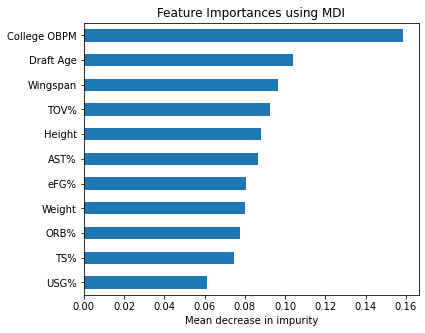

In [11]:
#feature importance
#the reason I do nsmallest is because I want the most important feature at the top. I only have 6 features,
#so nsmallest(6) takes all the features and orders them the way I want them to be ordered
feat_importances = pd.Series(rf_offense.feature_importances_, index=offense_X_train.columns).nsmallest(13)
fig, ax = plt.subplots(figsize=(6, 5))
feat_importances.plot(kind="barh", ax=ax)
ax.set_title("Feature Importances using MDI")
ax.set_xlabel("Mean decrease in impurity")
None

In [12]:
offense_X_test["predictions"] = rf_offense.predict(offense_X_test)
offense_X_test["predictions"] = round(offense_X_test["predictions"].astype(float), 2)

In [13]:
offense_X_test["actual"] = offense_Y_test
offense_X_test = offense_X_test.sort_values(by="predictions", ascending=False)
#put player's names next to their prediction
players = []
for index in offense_X_test.index:
    player_name = offense.iloc[index]["Player"]
    players.append(player_name)
offense_X_test["Player"] = np.array(players)
offense_X_test.head(10)

,Draft Age,Height,Weight,Wingspan,TS%,eFG%,ORB%,AST%,TOV%,USG%,College OBPM,predictions,actual,Player
15,-1.013183,-0.743358,-0.964264,-1.345898,0.594975,0.107521,-1.166958,2.636350,1.084242,2.423206,9.700,1.93,5.3,Trae Young
65,-0.867936,1.263403,-0.798909,1.928416,0.409570,0.057989,0.122306,0.102710,0.983655,-0.792448,5.300,0.95,3.9,Shai Gilgeous-Alexander
78,0.370367,-1.630364,-0.673862,-0.731402,0.549161,1.118455,3.482763,-0.436997,0.662811,0.199391,6.200,0.24,1.2,Kenneth Faried
31,-1.392422,1.467820,-1.032178,0.772036,2.882440,3.050514,-1.138506,-1.551245,-0.730658,-1.930798,4.600,0.22,0.6,Jaxson Hayes
2,1.593610,1.137980,-0.693684,0.387562,1.680919,1.147692,0.800866,0.452429,0.089433,-0.700844,8.000,0.20,1.4,Delon Wright
76,0.148789,1.012558,-0.152522,0.098652,2.210647,2.485055,-0.737429,-0.178806,-0.357510,-1.180231,6.800,0.19,-1.0,Landry Shamet
38,-0.112757,1.204589,-0.187184,0.214978,0.500910,0.757536,-0.035660,-0.617162,-1.438576,-0.356170,7.543,-0.02,-2.3,Sam Dekker
41,0.668619,-0.116245,-0.137490,0.483866,1.919296,1.197224,-0.759822,-0.114825,-1.430442,1.555826,9.100,-0.21,4.3,Damian Lillard
85,1.283141,0.597049,0.767675,-1.290730,0.036222,0.352819,-0.578729,0.319617,-0.346855,-0.131608,4.867,-0.33,-2.6,Joe Harris
12,-0.443554,0.352860,0.574431,-0.702612,-0.581303,-0.305788,-0.368659,0.427594,-0.449036,1.290727,8.300,-0.35,0.2,Jordan Hamilton


In [14]:
defense_X_train, defense_X_test, defense_Y_train, defense_Y_test = train_test_split(defense_X, defense_Y, 
                                                                                    test_size=.25, random_state=42)

In [15]:
#random forest defense
rf_defense = RandomForestRegressor(random_state=42)
rf_defense.fit(defense_X_train, defense_Y_train)

RandomForestRegressor(random_state=42)

**Observe feature importance for defense.**

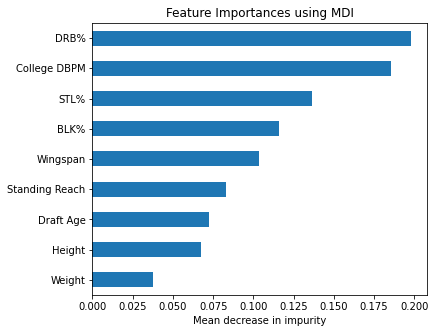

In [16]:
#feature importance
#the reason I do nsmallest is because I want the most important feature at the top. I only have 6 features,
#so nsmallest(13) takes all the features and orders them the way I want them to be ordered
feat_importances = pd.Series(rf_defense.feature_importances_, index=defense_X_train.columns).nsmallest(13)
fig, ax = plt.subplots(figsize=(6, 5))
feat_importances.plot(kind="barh", ax=ax)
ax.set_title("Feature Importances using MDI")
ax.set_xlabel("Mean decrease in impurity")
None

In [17]:
defense_X_test["predictions"] = rf_defense.predict(defense_X_test)
defense_X_test["predictions"] = round(defense_X_test["predictions"].astype(float), 2)

In [18]:
defense_X_test["actual"] = defense_Y_test
defense_X_test = defense_X_test.sort_values(by="predictions", ascending=False)
#put player's names next to their prediction
players = []
for index in defense_X_test.index:
    player_name = defense.iloc[index]["Player"]
    players.append(player_name)
defense_X_test["Player"] = np.array(players)
defense_X_test.head(10)

,Draft Age,Height,Weight,Wingspan,Standing Reach,DRB%,STL%,BLK%,College DBPM,predictions,actual,Player
60,-1.005139,-0.285938,0.496715,1.820762,1.137836,2.181293,1.072386,-0.227261,3.900,0.89,3.0,Kawhi Leonard
2,1.593610,1.137980,-0.693684,0.387562,1.183763,1.416088,1.283403,2.283875,6.500,0.85,1.8,Delon Wright
55,-1.169168,-0.971730,-0.330953,0.546741,1.604011,1.364990,-1.225680,1.666630,6.000,0.85,0.4,Myles Turner
18,1.295472,-0.868780,0.418703,-0.864381,-1.022341,0.576558,1.793814,-0.004894,5.327,0.73,0.9,Jevon Carter
9,0.881016,-1.812610,-0.016947,-0.194460,-1.085930,1.366023,1.972834,-0.702650,5.600,0.57,2.8,Draymond Green
30,0.913244,0.510867,1.080123,1.157989,0.674662,1.591955,1.741792,0.545906,5.367,0.53,0.2,Kris Dunn
42,-0.116649,-2.442473,0.475227,0.701976,-1.608524,-0.125976,1.483479,-0.176113,5.133,0.48,-0.6,Donovan Mitchell
16,-0.518022,-0.354641,1.929907,-0.194460,-0.867563,0.826583,0.610418,-0.768119,3.533,0.40,-0.2,Jared Sullinger
90,0.349382,-1.448118,-1.796588,-1.160956,-1.304296,1.633774,2.774957,-0.166452,4.286,0.35,1.3,Andre Roberson
65,-0.867936,1.263403,-0.798909,1.928416,2.032265,-0.533475,0.073138,0.611805,3.700,0.33,0.2,Shai Gilgeous-Alexander


## 2022  Predictions

**I put together the modeling.csv file before the draft withdrawal deadline so there are players that withdrew that I am going to remove from the dataset.**

**The players I am removing are Drew Timme, Matthew Mayer, Jalen Wilson, Julian Strawther, Terquavion Smith, and Harrison Ingram**

In [19]:
#read in the data
df_2022 = pd.read_csv("modeling_2022.csv")
#drop players that are returning to college
df_2022 = df_2022.drop([7, 14, 29, 37, 48, 50]).reset_index(drop=True)
#inspect the data
df_2022.head()

,Player,Position,Draft Year,Draft Age,Class,School,Height,Weight,Wingspan,Standing Reach,...,TRB%,AST%,STL%,BLK%,TOV%,USG%,PProd,College OBPM,College DBPM,College BPM
0,Keegan Murray,PF,2022,21.84,SO,Iowa,80.00,225.0,83.00,104.0,...,14.867,8.467,2.400,6.667,6.967,25.967,554.000,10.3,2.933,13.233
1,Chet Holmgren,PF,2022,20.15,FR,Gonzaga,84.00,195.0,90.00,115.0,...,19.600,11.400,1.600,12.600,15.700,21.600,424.000,7.5,7.500,15.000
2,Tari Eason,PF,2022,21.12,SO,Louisiana State,78.75,217.4,86.00,107.5,...,15.200,10.100,4.500,6.200,13.800,31.800,506.000,9.0,5.700,14.700
3,Walker Kessler,C,2022,20.91,SO,Auburn,84.25,256.0,88.25,113.0,...,16.600,6.900,2.400,19.100,10.700,19.000,360.000,6.2,8.000,14.100
4,Mark Williams,C,2022,20.52,SO,Duke,84.00,242.4,90.50,117.0,...,17.400,7.900,1.533,10.800,11.700,19.333,323.333,7.2,4.433,11.567


In [20]:
standardized_df_2022 = standardize_by_position(df_2022)
standardized_df_2022.head()

,Player,Position,Draft Year,Draft Age,Class,School,Height,Weight,Wingspan,Standing Reach,...,TRB%,AST%,STL%,BLK%,TOV%,USG%,PProd,College OBPM,College DBPM,College BPM
0,Chet Holmgren,PF,2022,-0.385861,FR,Gonzaga,1.848094,-1.891928,2.374662,2.357735,...,1.767230,-0.261635,-0.496167,2.491892,1.105633,-1.432230,-0.440567,7.5,7.500,15.000
1,Tari Eason,PF,2022,0.269734,SO,Louisiana State,-0.510523,-0.666452,0.466258,0.082728,...,0.135650,-0.644933,2.539453,0.436964,0.396285,1.675112,0.346495,9.0,5.700,14.700
2,Walker Kessler,C,2022,-0.067555,SO,Auburn,1.376494,0.418898,0.185431,0.414505,...,-0.337747,-0.608620,1.312661,2.152733,-1.308349,-0.674981,-0.174418,6.2,8.000,14.100
3,Keegan Murray,PF,2022,0.756362,SO,Iowa,0.051052,-0.250666,-0.965045,-0.978943,...,0.012169,-1.126415,0.341245,0.586910,-2.154757,-0.101861,0.807214,10.3,2.933,13.233
4,Mark Williams,C,2022,-0.371552,SO,Duke,1.223551,-0.170448,1.550880,1.771065,...,0.031488,-0.477228,-0.421625,0.584399,-0.940042,-0.621155,-0.571346,7.2,4.433,11.567


**TODO: Come back to this to comment on standardization of predicted values**

In [21]:
def model_analysis(start_df = standardized_modeling.copy(deep=True),
                   model_o = RandomForestRegressor(random_state=42), model_d = RandomForestRegressor(random_state=42), 
                   end_df = standardized_df_2022.copy(deep=True),
             features_o = ["Draft Age", "Height", "Weight", "Wingspan", "Standing Reach", "College OBPM"],
             features_d = ["Draft Age", "Height", "Weight", "Wingspan", "Standing Reach", "College DBPM"],
             sorting_column = "Predicted BPM"):
    #set up feature and target subsets for modeling
    offense_X = start_df[features_o]
    defense_X = start_df[features_d]
    offense_Y = start_df["Season3 OBPM"]
    defense_Y = start_df["Season3 DBPM"]
    #train test split for offense and defense
    offense_X_train, offense_X_test, offense_Y_train, offense_Y_test = train_test_split(offense_X, offense_Y, 
                                                                                    test_size=.25, random_state=42)
    defense_X_train, defense_X_test, defense_Y_train, defense_Y_test = train_test_split(defense_X, defense_Y, 
                                                                                    test_size=.25, random_state=42)

    #set up the machine learning model for offense
    model_offense = model_o
    #fit the model
    model_offense.fit(offense_X_train, offense_Y_train)
    #assess score of the model
    o_score = model_offense.score(offense_X_test, offense_Y_test)
    #repeat for defense
    model_defense = model_d
    #fit the model
    model_defense.fit(defense_X_train, defense_Y_train)
    #assess score of the model
    d_score = model_defense.score(defense_X_test, defense_Y_test)
    #print(f"The offensive model had a score of {o_score} \nThe defensive model had a score of {d_score}")
    
    #get names of models for plot titles
    model_name_o = " ".join(re.findall("[A-Z][^A-Z]*", str(model_o).split("(")[0]))
    model_name_d = " ".join(re.findall("[A-Z][^A-Z]*", str(model_d).split("(")[0]))
    try:
        #series of feature importances for offense and defense
        feat_importances_o = pd.Series(model_offense.feature_importances_, index=offense_X_train.columns).nsmallest(len(features_o))
        feat_importances_d = pd.Series(model_defense.feature_importances_, index=defense_X_train.columns).nsmallest(len(features_d))
        #set up plot structure
        fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(6, 8))
        plt.subplots_adjust(hspace=.5)
        #make the plots
        feat_importances_o.plot(kind="barh", ax=ax[0])
        feat_importances_d.plot(kind="barh", ax=ax[1])
        #set titles for plots
        ax[0].set_title(f"Feature Importances for Offensive {model_name_o}")
        ax[0].set_xlabel("Mean decrease in impurity")
        ax[1].set_title(f"Feature Importances for Offensive {model_name_d}")
        ax[1].set_xlabel("Mean decrease in impurity")
    except AttributeError:
        print(f"At least one of {model_name_o}, {model_name_d} has no feature importances")
    
    #add predictions to final df
    end_df["Predicted OBPM"] = model_offense.predict(end_df[features_o])
    end_df["Predicted DBPM"] = model_defense.predict(end_df[features_d])
    #standardize the predicted columns
    end_df["Predicted OBPM"] = (end_df["Predicted OBPM"] - end_df["Predicted OBPM"].mean()) / end_df["Predicted OBPM"].std()
    end_df["Predicted DBPM"] = (end_df["Predicted DBPM"] - end_df["Predicted DBPM"].mean()) / end_df["Predicted DBPM"].std()
    #add them together (variable is z scores)
    end_df["Predicted BPM"] = end_df["Predicted OBPM"] + end_df["Predicted DBPM"]
    #sort final df
    end_df = end_df.sort_values(by=sorting_column, ascending=False).reset_index(drop=True)
    return(end_df)
    
    

In [22]:
o_cols = ['Draft Age', 'Height', 'Weight', 'Wingspan','College OBPM']
d_cols = ['Draft Age', 'Height', 'Weight', 'Wingspan', 'College DBPM']

**Add columns that have the prospect rankings by overall, offense, defense as well as position**

In [23]:
rankings = model_analysis(sorting_column = "Predicted BPM", features_o = o_cols, features_d = d_cols,
              model_o = RandomForestRegressor(random_state=42), 
              model_d = LinearRegression())
rankings["Overall Ranking"] = np.arange(len(rankings)) + 1
rankings["Offensive Ranking"] = rankings["Predicted OBPM"].rank(ascending=False).astype(int)
rankings["Defensive Ranking"] = rankings["Predicted DBPM"].rank(ascending=False).astype(int)
rankings["Position Rank"] = rankings.groupby("Position")["Predicted BPM"].rank(ascending=False).astype(int)
rankings["Position Offensive Ranking"] = rankings.groupby("Position")["Predicted OBPM"].rank(ascending=False).astype(int)
rankings["Position Defensive Ranking"] = rankings.groupby("Position")["Predicted DBPM"].rank(ascending=False).astype(int)
rankings = rankings[["Player", "Overall Ranking", "Offensive Ranking", "Defensive Ranking", "Position Rank",
                    "Position Offensive Ranking", "Position Defensive Ranking"]]
rankings = pd.merge(rankings, df_2022, on="Player")
rankings

At least one of Random Forest Regressor, Linear Regression has no feature importances


,Player,Overall Ranking,Offensive Ranking,Defensive Ranking,Position Rank,Position Offensive Ranking,Position Defensive Ranking,Position,Draft Year,Draft Age,...,TRB%,AST%,STL%,BLK%,TOV%,USG%,PProd,College OBPM,College DBPM,College BPM
0,Chet Holmgren,1,3,1,1,2,1,PF,2022,20.15,...,19.600,11.400,1.600,12.600,15.700,21.600,424.000,7.500,7.500,15.000
1,Walker Kessler,2,4,2,1,1,1,C,2022,20.91,...,16.600,6.900,2.400,19.100,10.700,19.000,360.000,6.200,8.000,14.100
2,Jabari Smith,3,1,14,2,1,5,PF,2022,19.11,...,13.600,14.000,2.100,3.800,11.100,27.600,519.000,7.400,3.800,11.100
3,Tari Eason,4,6,3,3,3,2,PF,2022,21.12,...,15.200,10.100,4.500,6.200,13.800,31.800,506.000,9.000,5.700,14.700
4,AJ Griffin,5,2,41,1,1,4,SF,2022,18.83,...,9.100,7.000,1.300,2.300,7.200,18.800,349.000,6.600,1.500,8.100
5,Kennedy Chandler,6,8,9,1,1,1,PG,2022,19.77,...,6.000,32.300,4.100,0.900,16.200,25.000,479.000,4.200,4.800,9.000
6,Mark Williams,7,14,5,2,4,3,C,2022,20.52,...,17.400,7.900,1.533,10.800,11.700,19.333,323.333,7.200,4.433,11.567
7,Jeremy Sochan,8,10,12,4,6,4,PF,2022,19.09,...,14.700,12.300,2.900,3.200,15.600,19.600,282.000,3.600,4.400,8.000
8,Keegan Murray,9,7,20,5,4,6,PF,2022,21.84,...,14.867,8.467,2.400,6.667,6.967,25.967,554.000,10.300,2.933,13.233
9,Keon Ellis,10,24,6,1,7,1,SG,2022,22.46,...,10.933,10.233,3.367,2.100,15.667,16.200,316.000,4.500,4.533,9.033


**Download file with rankings to 2022_rankings.csv**

In [24]:
# filename = "2022_rankings.csv"
# if not os.path.exists(filename):
#     rankings.to_csv(filename, index=False)
#     print(f"Saved file with player rankings and stats to file {filename}")
# else:
#     print(f"file {filename} already exists")

In [25]:
o = ['Draft Age', 'Height', 'Weight', 'Wingspan','College OBPM','PProd','USG%','ORB%','eFG%']
d = ['Draft Age', 'Height', 'Weight', 'Wingspan', 'College DBPM','DRB%','STL%','BLK%']
#this gets all feature combinations and removes the combination of 0 features
d_combinations = sum([list(map(list, combinations(d, i))) for i in range(len(d) + 1)], [])[1:]
o_combinations = sum([list(map(list, combinations(o, i))) for i in range(len(o) + 1)], [])[1:]

## Visualizations

In [26]:
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
import plotly

**This function creates a dataframe where each value represents the player's percentile rank by position compared to everyone in the standardized modeling dataframe and 2022 dataframe that played the same position. College players that had at least 1 season playing 75% of their team's games AND that registered 700 or more minutes in their 3rd NBA season after being drafted were included in the standardized modeling dataframe.**

In [27]:
def get_percentile(final_df = pd.DataFrame()):
    #make a dataframe that has 2022 players in comparison to all other players from previous years
    percentile = standardized_modeling.append(standardized_df_2022).sort_values(by="Position").reset_index(drop=True)
    #loop through columns
    for col in percentile.columns:
        #if the column isn't numeric then we don't need a percentile
        #percentile for draft year or RSCI ranking doesn't tell us much
        if percentile[col].dtype == "O" or col in ["Draft Year", "RSCI Ranking"]:
            final_df[col] = percentile[col]
            continue
        #2022 players don't have this so break the loop 
        if col == "Season3 OBPM":
            break
        
        
        column_list = []
        #loop through positions for numeric columns that I want percentile ranks for by position
        for position in percentile.Position.unique():
            #create dataframe for that position
            position_df = percentile[percentile.Position == position]
            #append list converted from a pandas series to the list that will contain all positions
            column_list.append(position_df[col].rank(pct = True).tolist())
        
        #convert the list of lists into a numpy array that will serve as the column as percentiles
        final_df[col] = np.concatenate(column_list)
        #if it is one of these we want low numbers (want younger players and less turnovers)
        #I would consider a player with a low turnover rate to be in the higher percentile rank for this measure
        #so I will take 1-percentile to reflect this
        if col in ["Draft Age", "TOV%"]:
            final_df[col] = 1 - final_df[col]
        
    
    return(final_df)

In [28]:
percentile = get_percentile()
percentile.head()

,Player,Position,Draft Year,Draft Age,Class,School,Height,Weight,Wingspan,Standing Reach,...,TRB%,AST%,STL%,BLK%,TOV%,USG%,PProd,College OBPM,College DBPM,College BPM
0,Christian Koloko,C,2022,0.166667,JR,Arizona,0.625000,0.083333,0.875000,0.729167,...,0.291667,0.375000,0.416667,0.666667,0.625000,0.250000,0.166667,0.375000,0.708333,0.541667
1,Dewayne Dedmon,C,2013,0.000000,JR,Southern California,0.312500,0.416667,0.708333,0.458333,...,0.958333,0.291667,1.000000,0.833333,0.166667,0.208333,0.041667,0.041667,0.833333,0.208333
2,Gorgui Dieng,C,2013,0.041667,JR,Louisville,0.166667,0.125000,0.604167,0.895833,...,0.708333,0.750000,0.791667,0.875000,0.291667,0.041667,0.541667,0.458333,0.916667,0.750000
3,Jarrett Allen,C,2017,0.875000,FR,Texas,0.041667,0.250000,0.916667,0.583333,...,0.333333,0.250000,0.208333,0.208333,0.250000,0.583333,0.666667,0.291667,0.166667,0.166667
4,Myles Turner,C,2015,0.833333,FR,Texas,0.166667,0.375000,0.708333,0.958333,...,0.666667,0.416667,0.125000,0.958333,0.708333,0.791667,0.333333,0.333333,0.875000,0.666667


In [29]:
#only interested in the 2022 players for visualization
percentile_2022 = percentile[percentile["Draft Year"] == 2022].reset_index(drop=True)
percentile_2022.head()

,Player,Position,Draft Year,Draft Age,Class,School,Height,Weight,Wingspan,Standing Reach,...,TRB%,AST%,STL%,BLK%,TOV%,USG%,PProd,College OBPM,College DBPM,College BPM
0,Christian Koloko,C,2022,0.166667,JR,Arizona,0.625000,0.083333,0.875000,0.729167,...,0.291667,0.375000,0.416667,0.666667,0.625000,0.250000,0.166667,0.375000,0.708333,0.541667
1,Trevion Williams,C,2022,0.333333,SR,Purdue,0.083333,0.833333,0.291667,0.104167,...,1.000000,0.958333,0.875000,0.166667,0.375000,1.000000,0.750000,0.833333,0.354167,0.791667
2,Orlando Robinson,C,2022,0.208333,JR,Fresno State,0.500000,0.666667,0.375000,0.416667,...,0.375000,0.875000,0.625000,0.458333,0.416667,0.875000,1.000000,0.708333,0.083333,0.458333
3,Mark Williams,C,2022,0.583333,SO,Duke,0.916667,0.520833,1.000000,1.000000,...,0.583333,0.458333,0.333333,0.750000,0.875000,0.333333,0.375000,0.916667,0.666667,0.916667
4,Walker Kessler,C,2022,0.458333,SO,Auburn,0.958333,0.750000,0.520833,0.729167,...,0.416667,0.333333,0.916667,1.000000,0.916667,0.291667,0.583333,0.750000,1.000000,1.000000


**This function takes a player and creates a plot the visualizes that player's percentile rankings as well as gives some basic information about that player.**

In [30]:
def percentile_plot(player):
    #create a player_df so I can retrieve player info
    player_df = df_2022[df_2022.Player == player]
    position = player_df.iloc[0]["Position"]
    class_year = player_df.iloc[0]["Class"]
    school = player_df.iloc[0]["School"]
    rsci = int(player_df.iloc[0]["RSCI Ranking"])
    #create a dataframe of the desired player (1x25 columns) and flip the rows and columns (25x1)
    #this allows you to plot a scatter plot with the column values (percentile rankings) as the y values
    df = percentile_2022[percentile_2022.Player == player].reset_index().swapaxes("index", "columns")
    #drop non numeric features
    df = df.drop(["index", "Player", "Position", "Draft Year", "Class", "School", "RSCI Ranking"])
    #set up plot figure 
    fig, ax = plt.subplots(figsize=(15, 8))
    #plot background color to white
    ax.set_facecolor("white")
    #this is an array containing the percentile rankings
    array_values = np.array(list(df[0]))
    #I want high percentile rankings associated with the color red (they will be associated with blue if no 1-array)
    colors = 1 - array_values 
    #plot the scatter plot with the features on the x-axis and the percentiles on the y-axis
    #s increases the size of the plots, c is the intensity of colors, cmap is a red blue color map
    #zorder means that the points will be plotted on top of the vertical lines added later
    plt.scatter(df.index, df[0], s=500, c=colors, cmap="RdBu", zorder=2)
    #set y limit to be slightly below 0 and above 1 so that text annotation above points of the 100% percentile 
    #or points at 0% percentile show up
    ax.set_ylim(-0.05, 1.05)
    #Rotate the x axis tick marks so that the column labels fit more nicely
    ax.tick_params(axis='x', labelrotation = 45)
    #remove all borders from the plot
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)
    #remove x axis tick marks
    ax.xaxis.set_ticks_position("none")
    #remove y axis tick marks and labels
    ax.get_yaxis().set_ticks([])
    #if there is a percentile ranking > 0.9 need to move the title up so it doesn't overlap with text annotation
    if len(array_values[array_values >= .95]) > 0:
        ax.set_title(f"Percentile Rankings for {player}", size=25, y=1.1)
        plt.suptitle(f"Position: {position}     School: {school}     Class: {class_year}     RSCI: {rsci}", y=.94, size=13)
    #if there is no high percentile plot title normally
    else:
        ax.set_title(f"Percentile Rankings for {player}", size=25, y=1.05)
        plt.suptitle(f"Position: {position}     School: {school}     Class: {class_year}     RSCI: {rsci}", y=.9, size=13)
    #plot vertical lines for each feature
    for i in range(0, len(df.index), 1):
        plt.axvline(i,0,.95, c="black", alpha=0.1, zorder=1)
    #add text over each scatter plot point indicating the percentile value
    for i in range(len(df)):
        plt.annotate(f"{float(df.iloc[i]):.2f}", (i-.4, float(df.iloc[i]) + .05), color="black", 
                     size=15, zorder=3)
    None
    
    return(df_2022[df_2022.Player == player])
    
    

**This function creates an interactive plot with a dropdown menu where you can access any player's percentile ranks from that drop down menu. The drop down menu is in alphabetical order by FIRST NAME**

In [31]:
def interactive_plot(name="AJ Griffin"):
    #sort the percentile_2022 dataframe so the dropdown menu is more organized
    sorted_df = percentile_2022.sort_values(by="Player")
    #set up the drop down menu 
    #options will be all players
    #setting value as AJ Griffin because he is at the top of the drop down list
    #Name the drop down menu as Player:
    player = widgets.Dropdown(
        options=list(sorted_df.Player.unique()),
        value=name,
        description='Player:',
    )
    #set up interactive plot that calls the percentile_plot() function that makes the percentile plot,
    #pass it the dropdown menu
    plot = interactive(percentile_plot, player=player)
    return(plot)

**This is an interactive plot showing the percentile ranks for 2022 prospects compared to other players in the modeling dataset. Remember that the modeling dataset consists of only players that 1) Played college basketball within the timespan of 2011-2019 as well as played at least 75% of their team's games for at least 1 year 2) Participated in the combine or were drafted 3) Played 700 or more minutes in their 3rd year after being drafted.**

**Notes: The player's position is the position that they were given at the NBA combine according to https://www.nba.com/stats/draft/combine-anthro/. If a player was unranked in their class for RSCI they were given a rank of one higher than the highest in that class**

In [32]:
interactive_plot() 

interactive(children=(Dropdown(description='Player:', options=('AJ Griffin', 'Alondes Williams', 'Aminu Mohamm…